# Alternating Transfers

1) Set up a "branched" network, where ae and classifier share bottom layers. 

Some useful code: https://github.com/deep-diver/CIFAR10-VGG19-Tensorflow/blob/master/CIFAR10-transfer-learning-tensornets.ipynb

tensorboard tutorial: https://github.com/martinwicke/tf-dev-summit-tensorboard-tutorial 

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
#import keras


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define Architectures

### NN 1 (MNIST AE)

In [2]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
#maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
encoded = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same', name='encoded')
# Now 7x7x8
#conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
#encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8


#Need some kinda of compression step here...



### Decoder
#upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
#conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
#upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
upsample2 = tf.image.resize_nearest_neighbor(encoded, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits, name='loss')
cost = tf.reduce_mean(loss, name='cost')
opt = tf.train.AdamOptimizer(0.001).minimize(cost, name='opt')

### NN2 MNIST Classifier

In [3]:
class_targets_lab_ = tf.placeholder(tf.int32, (None), name='class_targets_lab_')

class_flat1 = tf.layers.flatten(encoded)
#dense1 = tf.layers.dense(flat1, 128, activation=tf.nn.relu)
# Now 1*128
class_drop1 = tf.layers.dropout(class_flat1, rate = 0.5)
class_dense2 = tf.layers.dense(class_drop1, 64, activation=tf.nn.relu)
# Now 1*64
class_drop2 = tf.layers.dropout(class_dense2, rate = 0.5)
class_final = tf.layers.dense(class_drop2, 10, activation=tf.nn.softmax)
# 1*10

class_one_hot_labs = tf.one_hot(class_targets_lab_,10)

#loss1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=one_hot_labs, logits=final)
class_loss1 = tf.nn.softmax_cross_entropy_with_logits(labels=class_one_hot_labs, logits=class_final)
class_cost1 = tf.reduce_mean(class_loss1)
class_opt1 = tf.train.AdamOptimizer(0.001).minimize(class_cost1)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [ ]:
#tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [ ]:
#with tf.variable_scope('dense', reuse=True):
#    print(sess.run(tf.get_variable('kernel')).shape)

## Training/Testing Functions
### Train AE

In [4]:
def train_ae(data, epochs = 1, batch_size = 200):

    for e in range(epochs):
        print(data.train.num_examples//batch_size, "batches")
        for ii in range(data.train.num_examples//batch_size):
            batch = data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                             targets_: imgs})

            if ii%50==0: print("Epoch: {}/{}, batch {}...".format(e+1, epochs, ii), 
                               "Training loss: {:.4f}".format(batch_cost))

### Inference AE (Viz version)
To Do: look up better compression metric

In [5]:
def infer_ae_viz(data):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    in_imgs = data.test.images[:10]
    reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

    for images, row in zip([in_imgs, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    fig.tight_layout(pad=0.1)

### Train Classifier

In [6]:
def train_class(data, epochs = 1, batch_size = 200):
    for e in range(epochs):
        print(data.train.num_examples//batch_size, "batches")
        for ii in range(data.train.num_examples//batch_size):
            imgs = data.train.images[ii*batch_size : (ii+1)*batch_size].reshape((-1, 28, 28, 1))
            labs = data.train.labels[ii*batch_size : (ii+1)*batch_size]
            #print(labs.shape)
            #imgs = batch[0].reshape((-1, 28, 28, 1))
            batch_cost, _ = sess.run([class_cost1, class_opt1], feed_dict={inputs_: imgs,
                                                               class_targets_lab_: labs})

            if ii%50==0: print("Epoch: {}/{}, batch {}...".format(e+1, epochs, ii), 
                               "Training loss: {:.4f}".format(batch_cost))

### Inference Classifier

In [7]:
def infer_class(data):
    # Test accuracy
    test_preds = sess.run(class_final, feed_dict = {inputs_: data.test.images.reshape(-1,28,28,1)})
    test_preds_cat = [x.argmax() for x in test_preds]
    print(sum(test_preds_cat == data.test.labels)/len(test_preds_cat))

### Compress

In [8]:
def compress(data):
    return(sess.run(encoded, feed_dict = {inputs_: data.images.reshape(-1,28,28,1)}))

### WIP: Train AE Frozen
Is this even possible in TF?

In [ ]:
    #Compress (i.e., freeze bottleneck output)
    print("Compressing Images...")
    compressed = compress(mnist.train)


In [ ]:
compressed.shape

In [ ]:
#def train_ae_frozen(data, epochs = 1, batch_size = 200):
#    #Compress (i.e., freeze bottleneck output)
#    print("Compressing Images...")
#    compressed = compress(data.train)

    #Train top-half layers only
    print("Retraining Upper layers...")
    for e in range(epochs):
        print(data.train.num_examples//batch_size, "batches")
        for ii in range(data.train.num_examples//batch_size):
            batch = data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            imgs_comp = compressed[ii*batch_size : (ii+1)*batch_size]
            batch_cost, _ = sess.run([cost, opt], feed_dict={encoded: imgs_comp,
                                                             targets_: imgs})

            if ii%50==0: print("Epoch: {}/{}, batch {}...".format(e+1, epochs, ii), 
                               "Training loss: {:.4f}".format(batch_cost))

In [ ]:
train_ae_frozen(mnist)

## Execution
### Start Session

In [10]:
sess = tf.Session()
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)
#To Do: see mnist warning the first time this is run

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Initialize from file or randomly

!!! WARNING: restore not working !!!

In [38]:
start_fresh = True

saver = tf.train.Saver(max_to_keep=100000)

if start_fresh:
    tf.set_random_seed(1)
    sess.run(tf.global_variables_initializer())
else:
    saver.restore(sess, '../models/FILENAME')#tf.train.latest_checkpoint('../models/'))
    

In [39]:
def three_dig(i):
    if i<10: return("00" + str(i))
    elif i<100: return("0" + str(i))
    else: return(str(i))
    

In [40]:
for i in range(50): 
    
    tf.set_random_seed(i*42)
    
    print("Round", i)
    print("    training AE")
    train_ae(mnist)
    saver.save(sess, "../models/temp/round%s_ae"%three_dig(i))
    
    #Print class Accuracy (should be low)
    print("    ", infer_class(mnist))
    #To do: print AE accuracy
    
    print("    training Class")
    train_class(mnist)
    saver.save(sess, "../models/temp/round%s_class"%three_dig(i))

    #Print class Accuracy (should be high)
    print("    ", infer_class(mnist))
    #To do: print AE accuracy



Round 0
    training AE
300 batches
Epoch: 1/1, batch 0... Training loss: 0.6985
Epoch: 1/1, batch 50... Training loss: 0.2182
Epoch: 1/1, batch 100... Training loss: 0.1464
Epoch: 1/1, batch 150... Training loss: 0.1078
Epoch: 1/1, batch 200... Training loss: 0.1011
Epoch: 1/1, batch 250... Training loss: 0.0968
0.0993
     None
    training Class
300 batches
Epoch: 1/1, batch 0... Training loss: 2.3092
Epoch: 1/1, batch 50... Training loss: 1.8038
Epoch: 1/1, batch 100... Training loss: 1.6430
Epoch: 1/1, batch 150... Training loss: 1.6310
Epoch: 1/1, batch 200... Training loss: 1.6940
Epoch: 1/1, batch 250... Training loss: 1.6358
0.8441
     None
Round 1
    training AE
300 batches
Epoch: 1/1, batch 0... Training loss: 0.2837
Epoch: 1/1, batch 50... Training loss: 0.1028
Epoch: 1/1, batch 100... Training loss: 0.0947
Epoch: 1/1, batch 150... Training loss: 0.0947
Epoch: 1/1, batch 200... Training loss: 0.0900
Epoch: 1/1, batch 250... Training loss: 0.0914
0.8313
     None
    train

0.9644
     None
    training Class
300 batches
Epoch: 1/1, batch 0... Training loss: 1.4989
Epoch: 1/1, batch 50... Training loss: 1.4846
Epoch: 1/1, batch 100... Training loss: 1.4731
Epoch: 1/1, batch 150... Training loss: 1.4874
Epoch: 1/1, batch 200... Training loss: 1.4892
Epoch: 1/1, batch 250... Training loss: 1.4829
0.9818
     None
Round 13
    training AE
300 batches
Epoch: 1/1, batch 0... Training loss: 0.0812
Epoch: 1/1, batch 50... Training loss: 0.0741
Epoch: 1/1, batch 100... Training loss: 0.0757
Epoch: 1/1, batch 150... Training loss: 0.0738
Epoch: 1/1, batch 200... Training loss: 0.0751
Epoch: 1/1, batch 250... Training loss: 0.0749
0.9624
     None
    training Class
300 batches
Epoch: 1/1, batch 0... Training loss: 1.4896
Epoch: 1/1, batch 50... Training loss: 1.4710
Epoch: 1/1, batch 100... Training loss: 1.4779
Epoch: 1/1, batch 150... Training loss: 1.4953
Epoch: 1/1, batch 200... Training loss: 1.4770
Epoch: 1/1, batch 250... Training loss: 1.4831
0.98
     Non

Epoch: 1/1, batch 250... Training loss: 1.4731
0.981
     None
Round 25
    training AE
300 batches
Epoch: 1/1, batch 0... Training loss: 0.0813
Epoch: 1/1, batch 50... Training loss: 0.0720
Epoch: 1/1, batch 100... Training loss: 0.0720
Epoch: 1/1, batch 150... Training loss: 0.0715
Epoch: 1/1, batch 200... Training loss: 0.0726
Epoch: 1/1, batch 250... Training loss: 0.0743
0.9679
     None
    training Class
300 batches
Epoch: 1/1, batch 0... Training loss: 1.4857
Epoch: 1/1, batch 50... Training loss: 1.4757
Epoch: 1/1, batch 100... Training loss: 1.4778
Epoch: 1/1, batch 150... Training loss: 1.4833
Epoch: 1/1, batch 200... Training loss: 1.4759
Epoch: 1/1, batch 250... Training loss: 1.4711
0.9838
     None
Round 26
    training AE
300 batches
Epoch: 1/1, batch 0... Training loss: 0.0790
Epoch: 1/1, batch 50... Training loss: 0.0718
Epoch: 1/1, batch 100... Training loss: 0.0741
Epoch: 1/1, batch 150... Training loss: 0.0723
Epoch: 1/1, batch 200... Training loss: 0.0704
Epoch: 1

Epoch: 1/1, batch 200... Training loss: 0.0713
Epoch: 1/1, batch 250... Training loss: 0.0724
0.9743
     None
    training Class
300 batches
Epoch: 1/1, batch 0... Training loss: 1.4764
Epoch: 1/1, batch 50... Training loss: 1.4718
Epoch: 1/1, batch 100... Training loss: 1.4872
Epoch: 1/1, batch 150... Training loss: 1.4616
Epoch: 1/1, batch 200... Training loss: 1.4734
Epoch: 1/1, batch 250... Training loss: 1.4664
0.9797
     None
Round 38
    training AE
300 batches
Epoch: 1/1, batch 0... Training loss: 0.0872
Epoch: 1/1, batch 50... Training loss: 0.0709
Epoch: 1/1, batch 100... Training loss: 0.0714
Epoch: 1/1, batch 150... Training loss: 0.0712
Epoch: 1/1, batch 200... Training loss: 0.0721
Epoch: 1/1, batch 250... Training loss: 0.0711
0.9642
     None
    training Class
300 batches
Epoch: 1/1, batch 0... Training loss: 1.4969
Epoch: 1/1, batch 50... Training loss: 1.4667
Epoch: 1/1, batch 100... Training loss: 1.4697
Epoch: 1/1, batch 150... Training loss: 1.4727
Epoch: 1/1, b

Epoch: 1/1, batch 150... Training loss: 1.4692
Epoch: 1/1, batch 200... Training loss: 1.4672
Epoch: 1/1, batch 250... Training loss: 1.4663
0.9845
     None


In [42]:
train_ae(mnist)

300 batches
Epoch: 1/1, batch 0... Training loss: 0.0745
Epoch: 1/1, batch 50... Training loss: 0.0717
Epoch: 1/1, batch 100... Training loss: 0.0700
Epoch: 1/1, batch 150... Training loss: 0.0710
Epoch: 1/1, batch 200... Training loss: 0.0701
Epoch: 1/1, batch 250... Training loss: 0.0701


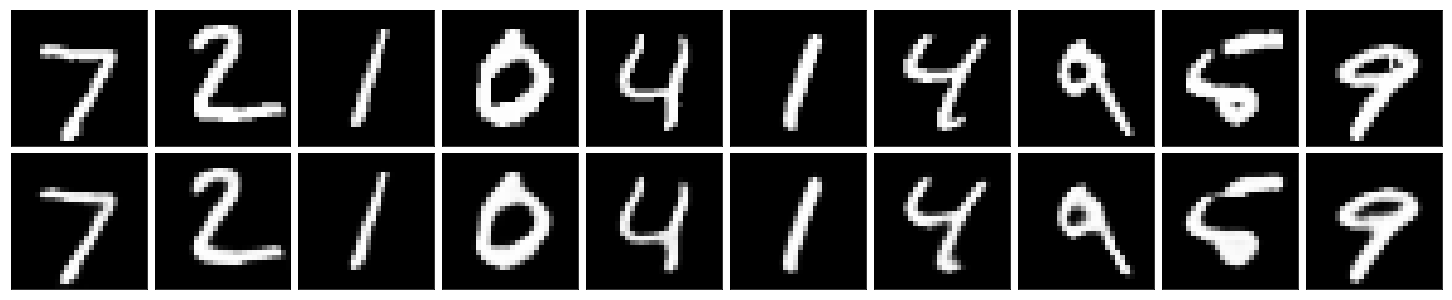

In [41]:
infer_ae_viz(mnist)

In [ ]:
train_class(mnist)
saver.save(sess, "../models/class_v001")

In [19]:
infer_class(mnist)

0.0752


Round 1?

300 batches
Epoch: 1/1, batch 0... Training loss: 0.6829
Epoch: 1/1, batch 50... Training loss: 0.1782
Epoch: 1/1, batch 100... Training loss: 0.1204
Epoch: 1/1, batch 150... Training loss: 0.1025
Epoch: 1/1, batch 200... Training loss: 0.0936
Epoch: 1/1, batch 250... Training loss: 0.0897

Round 2:

300 batches
Epoch: 1/1, batch 0... Training loss: 0.7201
Epoch: 1/1, batch 50... Training loss: 0.1020
Epoch: 1/1, batch 100... Training loss: 0.0953
Epoch: 1/1, batch 150... Training loss: 0.0927
Epoch: 1/1, batch 200... Training loss: 0.0912
Epoch: 1/1, batch 250... Training loss: 0.0942

Round 3:

300 batches
Epoch: 1/1, batch 0... Training loss: 0.1719
Epoch: 1/1, batch 50... Training loss: 0.0925
Epoch: 1/1, batch 100... Training loss: 0.0946
Epoch: 1/1, batch 150... Training loss: 0.0922
Epoch: 1/1, batch 200... Training loss: 0.0907
Epoch: 1/1, batch 250... Training loss: 0.0880

Round 4:

300 batches
Epoch: 1/1, batch 0... Training loss: 0.1090
Epoch: 1/1, batch 50... Training loss: 0.0894
Epoch: 1/1, batch 100... Training loss: 0.0893
Epoch: 1/1, batch 150... Training loss: 0.0869
Epoch: 1/1, batch 200... Training loss: 0.0858
Epoch: 1/1, batch 250... Training loss: 0.0840

Round 5:

300 batches
Epoch: 1/1, batch 0... Training loss: 0.0990
Epoch: 1/1, batch 50... Training loss: 0.0851
Epoch: 1/1, batch 100... Training loss: 0.0867
Epoch: 1/1, batch 150... Training loss: 0.0824
Epoch: 1/1, batch 200... Training loss: 0.0832
Epoch: 1/1, batch 250... Training loss: 0.0847

### AE Results

Round 1

300 batches
Epoch: 1/1, batch 0... Training loss: 2.3055
Epoch: 1/1, batch 50... Training loss: 1.8235
Epoch: 1/1, batch 100... Training loss: 1.6725
Epoch: 1/1, batch 150... Training loss: 1.6407
Epoch: 1/1, batch 200... Training loss: 1.6555
Epoch: 1/1, batch 250... Training loss: 1.6257

Round 2

300 batches
Epoch: 1/1, batch 0... Training loss: 1.6475
Epoch: 1/1, batch 50... Training loss: 1.6305
Epoch: 1/1, batch 100... Training loss: 1.6143
Epoch: 1/1, batch 150... Training loss: 1.5814
Epoch: 1/1, batch 200... Training loss: 1.6306
Epoch: 1/1, batch 250... Training loss: 1.6183

Round 3:

300 batches
Epoch: 1/1, batch 0... Training loss: 1.6529
Epoch: 1/1, batch 50... Training loss: 1.6107
Epoch: 1/1, batch 100... Training loss: 1.6054
Epoch: 1/1, batch 150... Training loss: 1.6203
Epoch: 1/1, batch 200... Training loss: 1.5574
Epoch: 1/1, batch 250... Training loss: 1.5753

Round 4:

300 batches
Epoch: 1/1, batch 0... Training loss: 1.6008
Epoch: 1/1, batch 50... Training loss: 1.6237
Epoch: 1/1, batch 100... Training loss: 1.6226
Epoch: 1/1, batch 150... Training loss: 1.5701
Epoch: 1/1, batch 200... Training loss: 1.5743
Epoch: 1/1, batch 250... Training loss: 1.5555

Round 5:

300 batches
Epoch: 1/1, batch 0... Training loss: 1.6018
Epoch: 1/1, batch 50... Training loss: 1.5357
Epoch: 1/1, batch 100... Training loss: 1.6070
Epoch: 1/1, batch 150... Training loss: 1.5750
Epoch: 1/1, batch 200... Training loss: 1.5945
Epoch: 1/1, batch 250... Training loss: 1.5624

## Looking promising! After alternating, I should still "freeze" the encoder and fine tune decoder and classifier portions for accuracy boost

## Save the models for later use

https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

In [ ]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
save_path = saver.save(sess, "../models/cheese")
print("Model saved in path: %s" % save_path)

In [ ]:
class_final

In [ ]:
saver.restore(sess, tf.train.latest_checkpoint('../models/cheese'))